In [1]:
import numpy as np
import random
import os
import PIL
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython import display
import pandas as pd
%matplotlib inline
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.regularizers import l2
from tensorflow.python.framework import ops
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
plt.rcParams['figure.figsize'] = (20, 15)



# Exploring the image data

In [2]:
path = '../input/marvel-character-images/data/'
labels = ['good', 'evil']

In [3]:
def show_random_images(path, labels):
        for i in range(20):
            label_idx = random.randint(0, len(labels)-1) # Select folder at random to choose from
            im_path = path + labels[label_idx] + '/'
            image_idx = random.randint(0, len([name for name in os.listdir(im_path)])-1) # Select image at random from folder
            image_names = [name for name in os.listdir(im_path) ]
            plt.subplot(4,5,i+1).set_title(labels[label_idx])
            plt.imshow(PIL.Image.open(im_path + image_names[image_idx]))

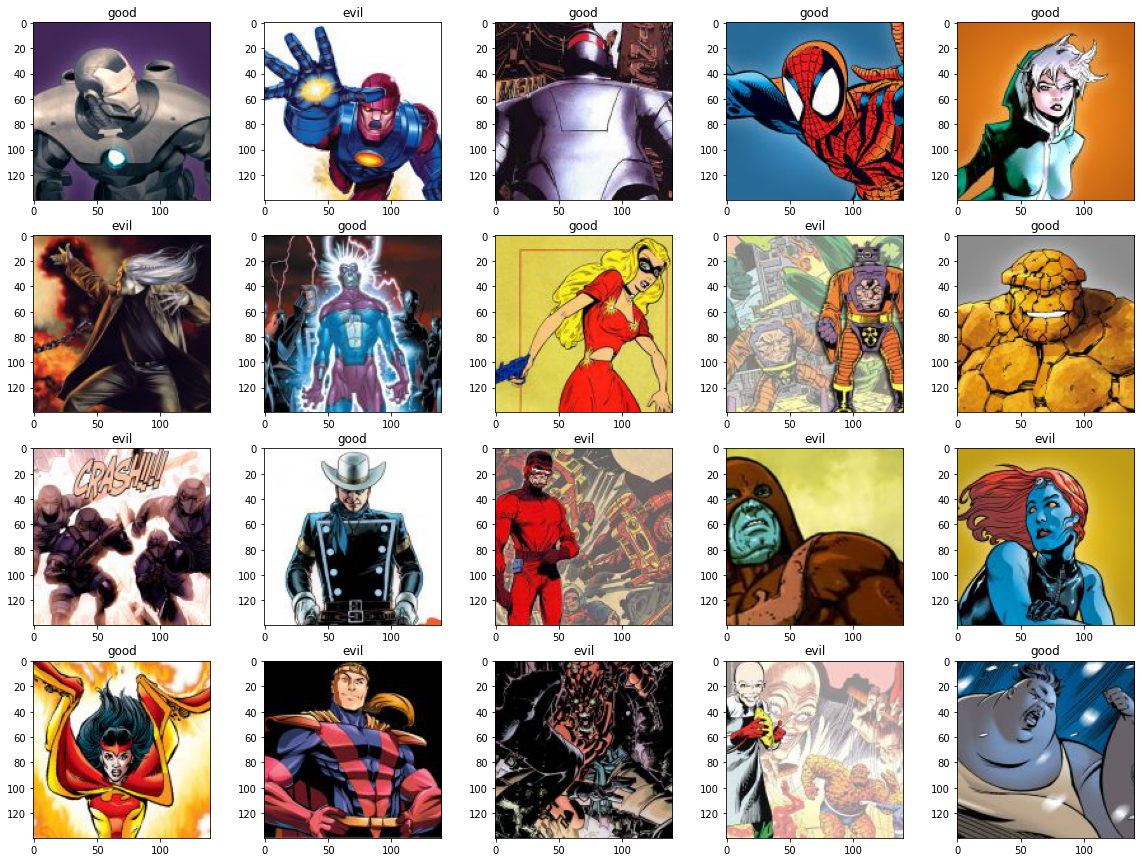

In [4]:
show_random_images(path, labels)

In [5]:
total_heroes = len([name for name in os.listdir(path + labels[0] + '/')])
total_villains = len([name for name in os.listdir(path + labels[1] + '/')])
total_images = total_heroes + total_villains

## Create an array of resized images
images = np.empty((total_images, 140, 140, 3),dtype=np.int32)
classes = np.empty(total_images,dtype=np.int32)
n = 0
for i in range(len(labels)):
    im_path = path + labels[i] + '/'
    for name in os.listdir(im_path):
        if labels[i] == 'good': classes[n] = 1
        if labels[i] == 'evil': classes[n] = 0
        images[n,:,:,:] = np.array(PIL.Image.open(im_path + name))
        n += 1

In [6]:
## Define function that will one-hot encode the target values
def one_hot_encode(target):
    n_values = np.max(target) + 1
    one_hot = np.eye(n_values)[target]
    return(one_hot)

X = images
y = classes.reshape(classes.shape[0], 1)

print('X shape:', X.shape)
print('y.shape:', y.shape)

X shape: (813, 140, 140, 3)
y.shape: (813, 1)


In [7]:
## Split X and y into training and test features + target.
seed=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=seed)


# Quick sanity check to make sure we have the desired array shapes
print("X training shape:", X_train.shape)
print("y training shape:", y_train.shape)
print("X testing shape:", X_test.shape)
print("y testing shape:", y_test.shape)

X training shape: (609, 140, 140, 3)
y training shape: (609, 1)
X testing shape: (204, 140, 140, 3)
y testing shape: (204, 1)


In [8]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip('horizontal'))   
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

In [9]:
class_weights = {0: 272.,
                1: 541.,
                }

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input #preprocess input with pre-trained weights

def transfer_model(image_shape=(140,140), data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape) 
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)   
    x = tfl.GlobalAveragePooling2D()(x) 
    x = tfl.Dropout(0.1)(x)
    x = tfl.Dense(512,activation='relu', kernel_regularizer=l2(0.1))(x)
    x = tfl.Dropout(0.1)(x)
    x = tfl.Dense(512,activation='relu', kernel_regularizer=l2(0.1))(x)
    outputs = tfl.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

model = transfer_model()

2022-02-17 19:11:29.925467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 19:11:30.047499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 19:11:30.048363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 19:11:30.049612: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
# Define initial epochs and base_learning rate and then compile
initial_epochs = 2000
base_lr = 1e-5
model.compile(optimizer=tf.optimizers.Adam(learning_rate=base_lr),
              loss='binary_crossentropy',
              metrics=['BinaryAccuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 140, 140, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 140, 140, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 140, 140, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 140, 140, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(4)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

history = model.fit(train_dataset, epochs=initial_epochs, validation_data=test_dataset,class_weight=class_weights)

2022-02-17 19:11:34.485414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2000


2022-02-17 19:11:38.041933: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


153/153 [==============================] - 11s 18ms/step - loss: 386.2586 - binary_accuracy: 0.6519 - val_loss: 124.7689 - val_binary_accuracy: 0.6667
Epoch 2/2000
153/153 [==============================] - 2s 13ms/step - loss: 363.8894 - binary_accuracy: 0.6700 - val_loss: 124.6343 - val_binary_accuracy: 0.6667
Epoch 3/2000
153/153 [==============================] - 2s 14ms/step - loss: 356.8857 - binary_accuracy: 0.6535 - val_loss: 124.5231 - val_binary_accuracy: 0.6716
Epoch 4/2000
153/153 [==============================] - 2s 13ms/step - loss: 346.9876 - binary_accuracy: 0.6683 - val_loss: 124.3944 - val_binary_accuracy: 0.6618
Epoch 5/2000
153/153 [==============================] - 2s 12ms/step - loss: 344.1918 - binary_accuracy: 0.6700 - val_loss: 124.2941 - val_binary_accuracy: 0.6618
Epoch 6/2000
153/153 [==============================] - 2s 12ms/step - loss: 341.7956 - binary_accuracy: 0.6880 - val_loss: 124.1902 - val_binary_accuracy: 0.6716
Epoch 7/2000
153/153 [============

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

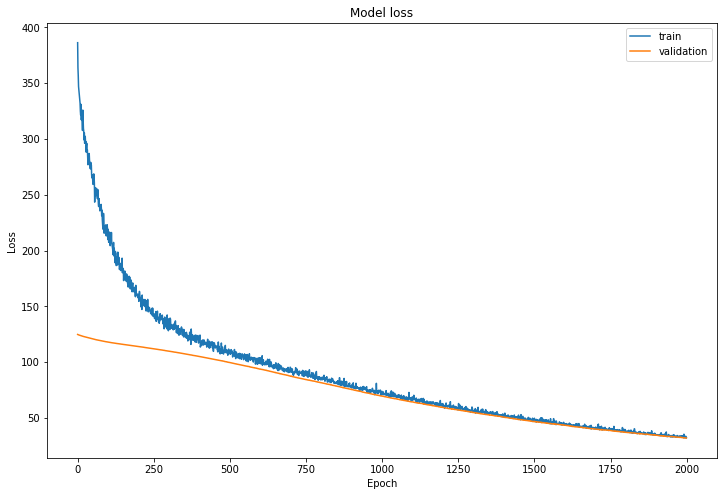

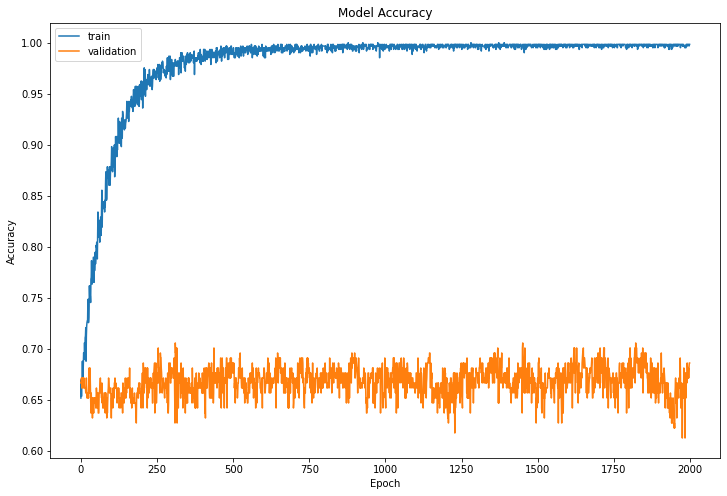

In [13]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['binary_accuracy','val_binary_accuracy']]
df_acc.rename(columns={'binary_accuracy':'train','val_binary_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [14]:
model.layers # See layers, freeze at base model (Functional)

In [15]:
base_model = model.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [16]:
fine_tune_at = 280 # Start fine tuning at this layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
model.compile(optimizer=tf.optimizers.Adam(learning_rate=base_lr*0.1),
              loss='binary_crossentropy',
              metrics=['BinaryAccuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 140, 140, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 140, 140, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 140, 140, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 140, 140, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [17]:
fine_tune_epochs = 30 # fine tune for 30 more epochs
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)

Epoch 2000/2030
153/153 [==============================] - 5s 17ms/step - loss: 30.0800 - binary_accuracy: 0.9967 - val_loss: 31.5428 - val_binary_accuracy: 0.6814
Epoch 2001/2030
153/153 [==============================] - 2s 13ms/step - loss: 29.7383 - binary_accuracy: 0.9967 - val_loss: 31.1769 - val_binary_accuracy: 0.6765
Epoch 2002/2030
153/153 [==============================] - 2s 13ms/step - loss: 29.4062 - binary_accuracy: 0.9984 - val_loss: 30.8268 - val_binary_accuracy: 0.6765
Epoch 2003/2030
153/153 [==============================] - 2s 12ms/step - loss: 29.0839 - binary_accuracy: 0.9984 - val_loss: 30.4855 - val_binary_accuracy: 0.6765
Epoch 2004/2030
153/153 [==============================] - 2s 13ms/step - loss: 28.7655 - binary_accuracy: 0.9984 - val_loss: 30.1453 - val_binary_accuracy: 0.6765
Epoch 2005/2030
153/153 [==============================] - 2s 12ms/step - loss: 28.4515 - binary_accuracy: 0.9984 - val_loss: 29.8102 - val_binary_accuracy: 0.6716
Epoch 2006/2030
